# Classification problem description. MNIST

Handwritten Digit Classification using PyTorch and the MNIST Dataset

# 1. Loading dataset and analizing dataset.

In [4]:
import torch
from torchvision import datasets # dataset
from torchvision.transforms import ToTensor # used to convert data to tensors.
import matplotlib.pyplot as plt

In [5]:
#importing dataset
data_mnist = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor() #Convert images to tensors.
)

In [7]:
# view dataset.
data_mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

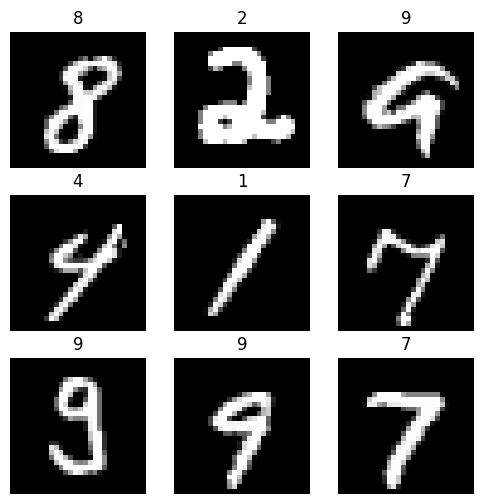

In [9]:
# Exploring random images on the dataset on a grid 3 x 3.
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(data_mnist), size=(1,)).item()
  img, label = data_mnist[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [10]:
print(f'Image data type: {type(img)}')
print(f'Image Shape {img.shape}')
print(f'Min Max: {img.min()}, {img.max()}')
print(f'Label: {type(label)} {label}')

Image data type: <class 'torch.Tensor'>
Image Shape torch.Size([1, 28, 28])
Min Max: 0.0, 1.0
Label: <class 'int'> 7


In [11]:
# Initializing seed
torch.manual_seed(42)

In [12]:
# we divide the data on three different sets for training, validation and test.
train, val, test = torch.utils.data.random_split(
    data_mnist, [0.8, 0.1, 0.1]
)


In [13]:
print(f'Length of train set: {len(train)}')
print(f'Length of val set: {len(val)}')
print(f'Length of test set: {len(test)}')


Length of train set: 48000
Length of val set: 6000
Length of test set: 6000


# 2. Creating the model - Neural network architecture.

Creating a linear layer and right after that a relu layer,

Relu will give the neural network the ability to learn problems that are not linear.

In [14]:
from torch import nn

class NeuralNetwork(nn.Module):

  def __init__(self):
    super().__init__()

    self.flatten = nn.Flatten()
    self.network = nn.Sequential(
        nn.Linear(28*28, 15),
        nn.ReLU(),
        nn.Linear(15, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.network(x)
    return logits

## load model into GPU (CUDA)

In [15]:
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device}")

model = NeuralNetwork().to(device)
print(model)

Using cuda
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=10, bias=True)
  )
)


In [16]:
total_params = sum(p.numel() for p in model.parameters())
print("Model parameters ", total_params)

Model parameters  11935


In [17]:
# extract image and category
img, lbl = train[200]

print(type(img))
print(type(lbl))

<class 'torch.Tensor'>
<class 'int'>


We see that the image is a Tensor while the category is an integer. We need to convert this category to a tensor in order to process it to the model.

In [18]:
lbl = torch.tensor(lbl).reshape(1)
print(type(lbl))

<class 'torch.Tensor'>


In [19]:
img, lbl = img.to(device), lbl.to(device)

In [20]:
logits = model(img)
print(logits)

tensor([[-0.2088, -0.1774,  0.2579,  0.1910,  0.0531, -0.1378, -0.1164, -0.0240,
         -0.3448,  0.0655]], device='cuda:0', grad_fn=<AddmmBackward0>)


# Initial test forward pass of the model.

Logits: tensor([[-0.2088, -0.1774,  0.2579,  0.1910,  0.0531, -0.1378, -0.1164, -0.0240,
         -0.3448,  0.0655]], device='cuda:0', grad_fn=<AddmmBackward0>)
Output: 2
Real label: 0


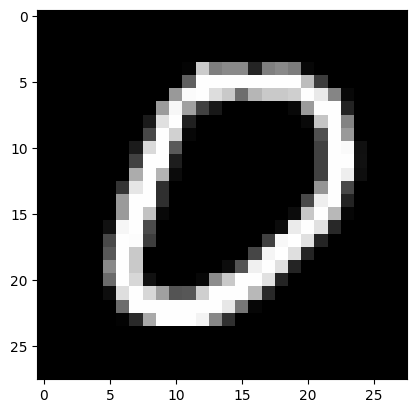

In [21]:
y_pred = logits.argmax(1)

plt.imshow(img.cpu().squeeze(), cmap="gray");

print(f'Logits: {logits}')
print(f'Output: {y_pred[0]}')
print(f'Real label: {lbl[0]}')

# Setting up the training - load datasets for validation and training.

In [22]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train,
    batch_size=1000,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val,
    batch_size=1000,
    shuffle=False
)

In [23]:
learning_rate = 0.1 # learning rate (0.1)
EPOCHS = 10 # Number of iterations for the training.

In [24]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [29]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_size = len(dataloader.dataset)
    nlotes = len(dataloader)

    # set training mode.
    model.train()

    training_loss, accuracy = 0, 0

    for nlote, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        # Forward pass.
        logits = model(X)

        # Backpropagation
        loss = loss_fn(logits, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # adding the training_loss and accuracy values.
        training_loss += loss.item()
        accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

        # print the resuls every 10.
        if nlote % 10 == 0:
            ndata = nlote*EPOCHS

            # E imprimir en pantalla
            print(f"\t Loss : {loss.item():>7f}  [{ndata:>5d}/{train_size:>5d}]")

    training_loss /= nlotes
    accuracy /= train_size

    print(f'\t Accuracy/Average loss :')
    print(f'\t\t Training.: {(100*accuracy):>0.1f}% / {training_loss:>8f}')

In [34]:
def val_loop(dataloader, model, loss_fn):

    val_size = len(dataloader.dataset)
    nlotes = len(dataloader)

    model.eval()

    validation_loss, validation_accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # foward passs.
            logits = model(X)

            validation_loss += loss_fn(logits, y).item()
            validation_accuracy += (logits.argmax(1) == y).type(torch.float).sum().item()

    validation_loss /= nlotes
    validation_accuracy /= val_size

    print(f"\t\t validation: {(100*validation_accuracy):>0.1f}% / {validation_loss:>8f} \n")

In [35]:
for t in range(EPOCHS):
    print(f"Iteration {t+1}/{EPOCHS}\n-------------------------------")
    # Train
    train_loop(train_loader, model, loss_function, optimizer)
    # Validate
    val_loop(val_loader, model, loss_function)
print("Ready, the model has been trained.")

Iteration 1/10
-------------------------------
	 Loss : 0.662250  [    0/48000]
	 Loss : 0.655419  [  100/48000]
	 Loss : 0.580280  [  200/48000]
	 Loss : 0.545163  [  300/48000]
	 Loss : 0.537800  [  400/48000]
	 Accuracy/Average loss :
		 Training.: 85.3% / 0.575955
		 validation: 86.7% / 0.525201 

Iteration 2/10
-------------------------------
	 Loss : 0.488619  [    0/48000]
	 Loss : 0.479263  [  100/48000]
	 Loss : 0.472558  [  200/48000]
	 Loss : 0.468731  [  300/48000]
	 Loss : 0.502401  [  400/48000]
	 Accuracy/Average loss :
		 Training.: 87.4% / 0.476404
		 validation: 87.7% / 0.460033 

Iteration 3/10
-------------------------------
	 Loss : 0.478097  [    0/48000]
	 Loss : 0.436889  [  100/48000]
	 Loss : 0.433473  [  200/48000]
	 Loss : 0.390268  [  300/48000]
	 Loss : 0.424252  [  400/48000]
	 Accuracy/Average loss :
		 Training.: 88.6% / 0.424865
		 validation: 88.4% / 0.424081 

Iteration 4/10
-------------------------------
	 Loss : 0.398682  [    0/48000]
	 Loss : 0.

In [36]:
def predict(model, img):
    logits = model(img)
    y_pred = logits.argmax(1).item()

    # show original image and its prediction.
    plt.imshow(img.cpu().squeeze(), cmap="gray")
    plt.title(f'Prediction: {y_pred}');

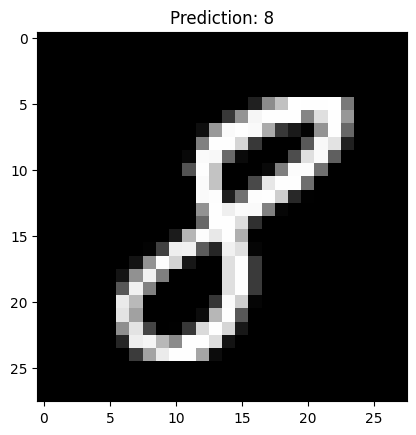

In [37]:
# take an image of the test set.
img, lbl = test[1235]
lbl = torch.tensor(lbl).reshape(1)
img, lbl = img.to(device), lbl.to(device)

# Y generar la predicción
predict(model, img)